# Feature Engineering, Modeling, and Prediction

# Part 1: Data Preparation

## Import libraries

In [65]:
'''
Predicting crimes in San Francisco
Building several classifiers to
predict crimes by category
'''
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import graphviz
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer

from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

# the XGBoost classifier

from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

## Load in data

In [4]:
# load the cleaned and engineered data
train = pd.read_csv('data/train_reduced.csv')
test = pd.read_csv('data/test_reduced.csv')

In [5]:
train.head(2)

,Category,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,ASSAULT,1/8/15 3:46,Thursday,MISSION,FOLSOM ST / 14TH ST,-122.415616,37.768536
1,VEHICLE THEFT,1/24/14 12:00,Thursday,TARAVAL,WILSON ST / RHINE ST,-122.461139,37.709085


## There is one sample in the test set that doesn't have police district info, drop it

In [6]:
test = test.dropna()

# Part 2: Feature Engineering

## Given the date infomation, let's extract hour, day, day of week, etc

In [7]:
def date_feature_engineering(df):
    df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y %H:%M")
    df['Day'] = df['Dates'].dt.day
    df['Month'] = df['Dates'].dt.month
    df['Year'] = df['Dates'].dt.year
    df['Hour'] = df['Dates'].dt.hour
    df['WeekOfYear'] = df['Dates'].dt.weekofyear
    df["Friday"] = np.where(df.DayOfWeek == "Friday", 1, 0)
    df["Saturday"] = np.where(df.DayOfWeek == "Saturday", 1, 0)
    df["Weekend"] = df["Friday"] + df["Saturday"]
    df = df.drop(["Friday", "Saturday"], axis=1)
    df['DayOfWeek'] = df['Dates'].dt.dayofweek
    return df

In [11]:
train = date_feature_engineering(train)
test = date_feature_engineering(test)

In [12]:
train.head(1)

,Category,Dates,DayOfWeek,PdDistrict,Address,X,Y,Day,Month,Year,Hour,WeekOfYear,Weekend
0,ASSAULT,2015-01-08 03:46:00,3,MISSION,FOLSOM ST / 14TH ST,-122.415616,37.768536,8,1,2015,3,2,0


## Now let's deal with longitude and latitude

In [19]:
def long_lat_engineering(df):
    # there are coordinates like (-120.5, 90) which is the coordinate 
    # for the North Pole. Drop these values
    df = df[df.X <-121]
    df = df[df.Y<40]
    
    # normalize the coordinates
    xy_scaler = preprocessing.StandardScaler() 
    xy_scaler.fit(df[["X","Y"]]) 
    df[["X","Y"]]=xy_scaler.transform(df[["X","Y"]]) 
    
    # use variants of rotated Cartesian coordinates (rotated by 30, 45, 60 degree each)     
    df["rot45_X"] = 0.707* df["Y"] + 0.707* df["X"]
    df["rot45_Y"] = 0.707* df["Y"] - 0.707* df["X"]
    df["rot30_X"] = 0.866* df["X"] + 0.5* df["Y"]
    df["rot30_Y"] = 0.866* df["Y"] - 0.5* df["X"]
    df["rot60_X"] = 0.5* df["X"] + 0.866* df["Y"]
    df["rot60_Y"] = 0.5* df["Y"] - 0.866* df["X"]
    
    # use polar coordinates
    df["radial_r"] = np.sqrt(np.power(df["Y"],2) + np.power(df["X"],2))
    
    # from the address feature, extract whether a crime happened in a street corner
    df['Street_corner'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)
    
    return df

In [20]:
train = long_lat_engineering(train)
test = long_lat_engineering(test)

## Encode the 'PdDistrict Variable'

In [21]:
# Label encoder
preProc = preprocessing.LabelEncoder()
train['PdDistrict'] = preProc.fit_transform(train.PdDistrict)
test['PdDistrict'] = preProc.transform(test.PdDistrict)

## Create the response variable and feature set

In [22]:
def response_feature_split(df):
    Y = df['Category']
    X = df.drop(['Address', 'Category', 'Dates'], axis=1)
    return X, Y

In [23]:
X_train, Y_train = response_feature_split(train)
X_test, Y_true = response_feature_split(test)

In [24]:
# encode Y
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_true = le.fit_transform(Y_true)

## Convert categorical variables into dummies (skip this step for now)

In [173]:
def get_dummy(df, col_name):
    one_hot = pd.get_dummies(df[col_name], prefix=col_name)
    df = df.drop(col_name, axis=1)
    df = df.join(one_hot)
    return df

X_train = get_dummy(X_train, 'Year')
X_train = get_dummy(X_train, 'PdDistrict')
X_train = get_dummy(X_train, 'WeekOfYear')
X_train = get_dummy(X_train, 'DayOfWeek')
X_train = get_dummy(X_train, 'Month')
X_train = get_dummy(X_train, 'Day')
X_train = get_dummy(X_train, 'Weekend')
X_train = get_dummy(X_train, 'Hour')
X_train = get_dummy(X_train, 'Street_corner')

X_test = get_dummy(X_test, 'Year')
X_test = get_dummy(X_test, 'PdDistrict')
X_test = get_dummy(X_test, 'WeekOfYear')
X_test = get_dummy(X_test, 'DayOfWeek')
X_test = get_dummy(X_test, 'Month')
X_test = get_dummy(X_test, 'Day')
X_test = get_dummy(X_test, 'Weekend')
X_test = get_dummy(X_test, 'Hour')
X_test = get_dummy(X_test, 'Street_corner')

# Part 3: Modeling

## Model 1: Extreme Gradient Boosting

In [ ]:
xgb = XGBClassifier(n_estimators=31,
                  learning_rate=0.2,
                  max_depth=11,
                  min_child_weight=4,
                  gamma=0.4,
                  reg_alpha=0.05,
                  reg_lambda=2,
                  subsample=1.0,
                  colsample_bytree=1.0,
                  max_delta_step=1,
                  scale_pos_weight=1,
                  objective='multi:softprob',
                  nthread=8,
                  seed=0)

xgb.fit(X_train, Y_train

In [ ]:
Y_pred = xgb.predict_proba(X_test)
Y_pred = pandas.DataFrame(Y_pred)
Y_pred.columns = xgb.classes_

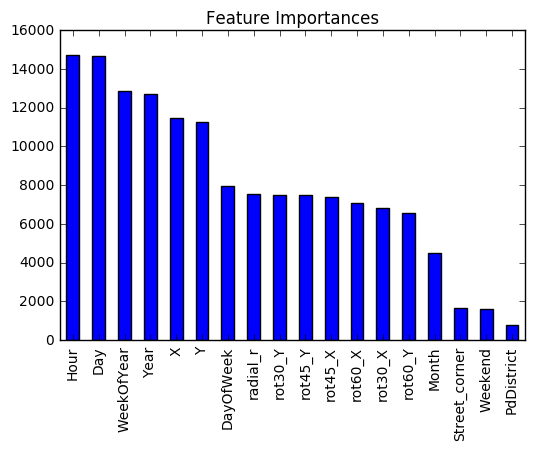

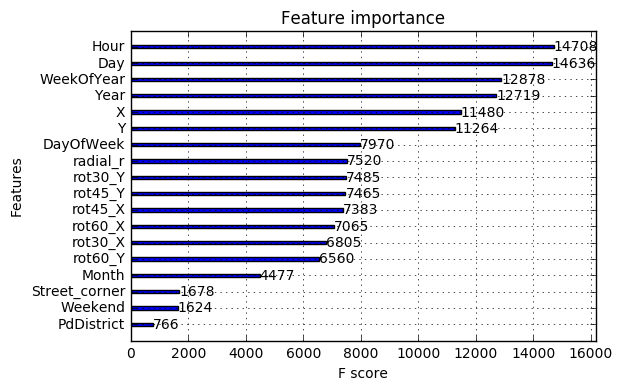

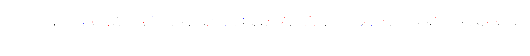

In [37]:
# print feature importance
feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()
plot_importance(xgb, title='Feature importance')
plt.show()
plot_tree(xgb, num_trees=0)
plt.show()

### On Kaggle, the scoring strategy is log loss, thus we follow the same option
#### the smaller the log loss values, the better the model is at predicting

In [284]:
score = cross_val_score(xgb, X_train, Y_train, n_jobs=-1, cv=5, scoring="neg_log_loss")
print score
print np.mean(score)

[-1.17 -1.16 -1.16 -1.16 -1.22]
-1.17363715384


- The No. 1 score on Kaggle is about 1.96. Even though we reduced the our prediction to the top 5 crime, we still did a good job.

## Model 2: Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 101)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=101, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [287]:
score = cross_val_score(rf, X_train, Y_train, n_jobs=-1, cv=5, scoring="neg_log_loss")
print score
print np.mean(score)

[-1.46 -1.38 -1.36 -1.33 -1.55]
-1.4136906897


## Model 3: Extra Trees

In [28]:
from sklearn.ensemble import ExtraTreesClassifier
etr = ExtraTreesClassifier(n_jobs=-1, n_estimators = 101)
etr.fit(X_train, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=101, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [64]:
score = cross_val_score(etr, X_train, Y_train, n_jobs=-1, cv=5, scoring="neg_log_loss")
print score
print np.mean(score)

[-2.155 -2.308 -2.294 -2.27  -1.917]
-2.18877756242


## Model 4 Linear Discriminant Analysis

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)

//anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [285]:
score = cross_val_score(lda, X_train, Y_train, n_jobs=-1, cv=5, scoring="neg_log_loss")
print score
print np.mean(score)

[-1.36 -1.37 -1.37 -1.37 -1.35]
-1.36637785989


## Model 5: Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [286]:
score = cross_val_score(lg, X_train, Y_train, n_jobs=-1, cv=5, scoring="neg_log_loss")
print score
print np.mean(score)

[-1.37 -1.37 -1.37 -1.37 -1.37]
-1.36840090423


# Part 5: Predict and plot confusion matrix

In [30]:
%matplotlib inline
width = 12
height = 20
plt.figure(figsize=(width, height))
class_names = set(Y_true)
import itertools
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Predictiong for Extreme Gradient Boosting

In [41]:
Y_pred = xgb.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)
Y_true = le.inverse_transform(Y_true)

Confusion matrix, without normalization
[[ 23699   9335  48407    616   5474]
 [  6802  29800  18456    134   1845]
 [ 12535   6543 178648    526   8861]
 [  8889   2018  35950    854   3970]
 [  6566   1618  36092    347  14693]]


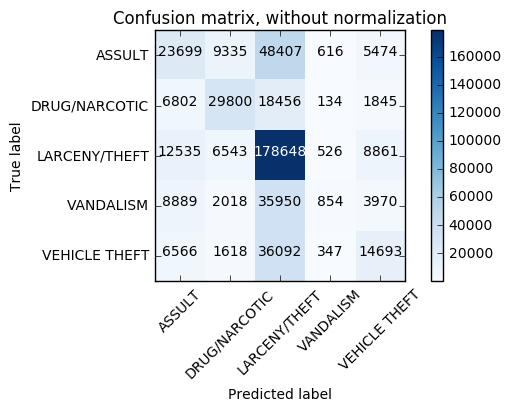

In [51]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred)
class_names = ['ASSULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# np.set_printoptions(precision=3)
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

               precision    recall  f1-score   support

      ASSAULT       0.41      0.27      0.32     87531
DRUG/NARCOTIC       0.60      0.52      0.56     57037
LARCENY/THEFT       0.56      0.86      0.68    207113
    VANDALISM       0.34      0.02      0.03     51681
VEHICLE THEFT       0.42      0.25      0.31     59316

  avg / total       0.50      0.54      0.48    462678



## 2. Prediction For Random Forest

Confusion matrix, without normalization
[[ 25210   8650  42904   4975   5792]
 [  8480  28343  16757   1422   2035]
 [ 16063   6303 165920   8415  10412]
 [  9135   2135  31568   4476   4367]
 [  7278   1873  34178   2376  13611]]


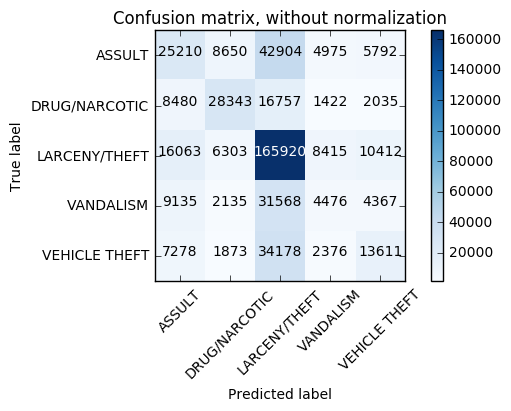

In [59]:
Y_pred = rf.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred)
class_names = ['ASSULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [60]:
print(classification_report(Y_true, Y_pred))

               precision    recall  f1-score   support

      ASSAULT       0.38      0.29      0.33     87531
DRUG/NARCOTIC       0.60      0.50      0.54     57037
LARCENY/THEFT       0.57      0.80      0.67    207113
    VANDALISM       0.21      0.09      0.12     51681
VEHICLE THEFT       0.38      0.23      0.28     59316

  avg / total       0.47      0.51      0.48    462678



## 3. Prediction For Extra Trees

Confusion matrix, without normalization
[[ 24653   8242  44310   5044   5282]
 [  8340  28006  17373   1398   1920]
 [ 15892   6118 168902   6824   9377]
 [  8956   2023  32164   4569   3969]
 [  7507   1828  35603   2978  11400]]


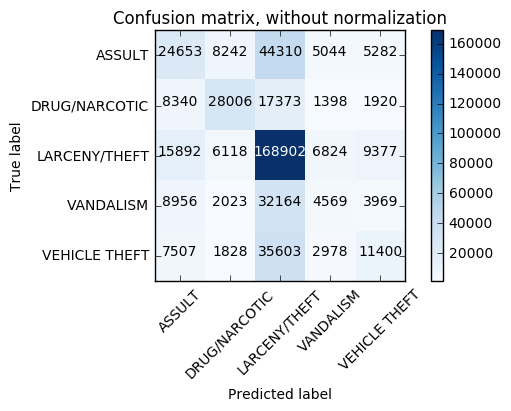

In [62]:
Y_pred = etr.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred)
class_names = ['ASSULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [63]:
print(classification_report(Y_true, Y_pred))

               precision    recall  f1-score   support

      ASSAULT       0.38      0.28      0.32     87531
DRUG/NARCOTIC       0.61      0.49      0.54     57037
LARCENY/THEFT       0.57      0.82      0.67    207113
    VANDALISM       0.22      0.09      0.13     51681
VEHICLE THEFT       0.36      0.19      0.25     59316

  avg / total       0.47      0.51      0.47    462678



## 4. Prediction For Linear Discriminant Analysis

In [53]:
Y_pred = lda.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

Confusion matrix, without normalization
[[  9467   1732  71439      0   4893]
 [  2602   4242  48011      0   2182]
 [  5927   3220 191291      0   6675]
 [  4950    534  43133      0   3064]
 [  5073    940  45358      0   7945]]


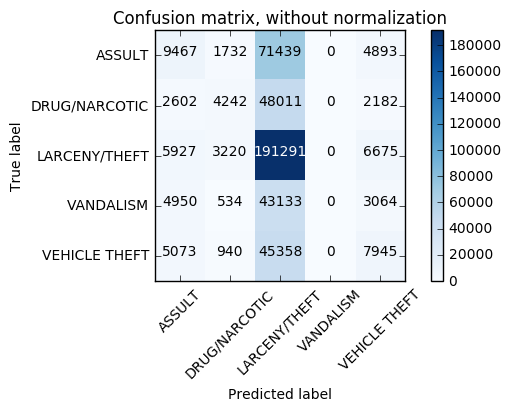

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred)
class_names = ['ASSULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [55]:
print(classification_report(Y_true, Y_pred))

               precision    recall  f1-score   support

      ASSAULT       0.34      0.11      0.16     87531
DRUG/NARCOTIC       0.40      0.07      0.13     57037
LARCENY/THEFT       0.48      0.92      0.63    207113
    VANDALISM       0.00      0.00      0.00     51681
VEHICLE THEFT       0.32      0.13      0.19     59316

  avg / total       0.37      0.46      0.35    462678



//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Prediction For Logistic Regression

Confusion matrix, without normalization
[[  9695     32  75911      0   1893]
 [  2324     28  53999      0    686]
 [  6237     86 198143      0   2647]
 [  5100     15  45344      0   1222]
 [  5605     12  51299      0   2400]]


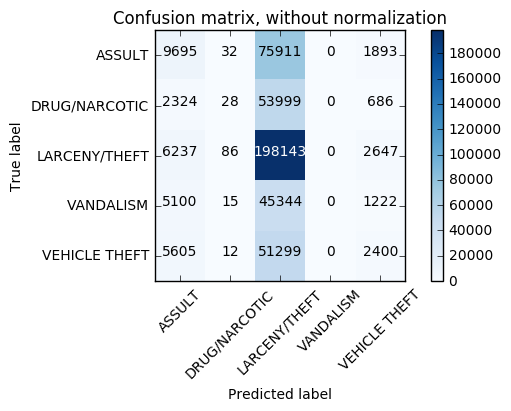

In [56]:
Y_pred = lg.predict(X_test)
Y_pred = le.inverse_transform(Y_pred)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_true, Y_pred)
class_names = ['ASSULT', 'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [57]:
print(classification_report(Y_true, Y_pred))

               precision    recall  f1-score   support

      ASSAULT       0.33      0.11      0.17     87531
DRUG/NARCOTIC       0.16      0.00      0.00     57037
LARCENY/THEFT       0.47      0.96      0.63    207113
    VANDALISM       0.00      0.00      0.00     51681
VEHICLE THEFT       0.27      0.04      0.07     59316

  avg / total       0.33      0.45      0.32    462678

